<a href="https://colab.research.google.com/github/stevecoffee/dasc5300/blob/main/Project2/DASC_5300_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!pip install python-igraph

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
from igraph import *    # https://igraph.org/python/tutorial/0.9.6/tutorial.html

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

Grabbed additional data from https://openflights.org/data.html:
- airports.dat
- airports-extended.dat
- routes.dat
- countries.dat


In [40]:
# load countries from openflight data
df_openflight_countries = pd.read_csv(
    'https://raw.githubusercontent.com/stevecoffee/dasc5300/main/Project2/data/OpenFlights/countries.dat',
    names=['name', 'iso-code', 'dafif-code'],
    skipinitialspace='true', header=0, na_values='\\N')
df_openflight_countries

,name,iso-code,dafif-code
0,Aruba,AW,AA
1,Antigua and Barbuda,AG,AC
2,United Arab Emirates,AE,AE
3,Afghanistan,AF,AF
4,Algeria,DZ,AG
...,...,...,...
255,Samoa,WS,WS
256,Eswatini,SZ,WZ
257,Yemen,YE,YM
258,Zambia,ZM,ZA


In [41]:
# load airlines from openflight data
df_openflight_airlines = pd.read_csv(
    'https://raw.githubusercontent.com/stevecoffee/dasc5300/main/Project2/data/OpenFlights/airlines.dat',
    names=['airline-id', 'name', 'alias', 'iata', 'icao', 'callsign', 'country', 'active'],
    skipinitialspace='true', header=0, na_values='\\N')
print(df_openflight_airlines)

      airline-id                                          name              alias iata icao         callsign         country active
0              1                                Private flight                NaN    -  NaN              NaN             NaN      Y
1              2                                   135 Airways                NaN  NaN  GNL          GENERAL   United States      N
2              3                                 1Time Airline                NaN   1T  RNX          NEXTIME    South Africa      Y
3              4  2 Sqn No 1 Elementary Flying Training School                NaN  NaN  WYT              NaN  United Kingdom      N
4              5                               213 Flight Unit                NaN  NaN  TFU              NaN          Russia      N
...          ...                                           ...                ...  ...  ...              ...             ...    ...
6156       21248                                   GX Airlines              

In [42]:
# load airports from openflight data
df_openflight_airports = pd.read_csv(
    'https://raw.githubusercontent.com/stevecoffee/dasc5300/main/Project2/data/OpenFlights/airports.dat',
    names=['airport-id', 'airport-name', 'city', 'country', 'iata', 'icao', 'latitude', 'longitude', 'altitude', 'timezone', 'DST', 'database-timezone', 'type', 'source'],
    skipinitialspace='true', header=0, na_values='\\N')
df_openflight_airports.drop(['airport-id', 'icao', 'altitude', 'timezone', 'DST', 'database-timezone', 'type', 'source'], axis='columns', inplace=True)
df_openflight_airports = df_openflight_airports[ df_openflight_airports['iata'].notna() ]
print(df_openflight_airports)

                                     airport-name                 city           country iata   latitude   longitude
0                                  Madang Airport               Madang  Papua New Guinea  MAG  -5.207080  145.789001
1                    Mount Hagen Kagamuga Airport          Mount Hagen  Papua New Guinea  HGU  -5.826790  144.296005
2                                  Nadzab Airport               Nadzab  Papua New Guinea  LAE  -6.569803  146.725977
3     Port Moresby Jacksons International Airport         Port Moresby  Papua New Guinea  POM  -9.443380  147.220001
4                     Wewak International Airport                Wewak  Papua New Guinea  WWK  -3.583830  143.669006
...                                           ...                  ...               ...  ...        ...         ...
7683                       Bilogai-Sugapa Airport  Sugapa-Papua Island         Indonesia  UGU  -3.739560  137.031998
7686                                Ramon Airport               

In [43]:
# load airports from data file provided with project
df_provided_airports = pd.read_csv(
    'https://raw.githubusercontent.com/stevecoffee/dasc5300/main/Project2/data/provided/AirportMapping.csv',
    skipinitialspace='true', na_values='\\N')
df_provided_airports.drop_duplicates('Code', inplace=True)
df_provided_airports.dropna(inplace=True)
print(df_provided_airports.count())
print(df_provided_airports[ df_provided_airports['Code'].isna() ])
# print(df_provided_airports[ df_provided_airports['Code'] == 'YGR' ])


City       1497
Country    1497
Code       1497
dtype: int64
Empty DataFrame
Columns: [City, Country, Code]
Index: []


In [44]:
df_merged_airports = df_provided_airports.merge(df_openflight_airports, how='inner', left_on='Code', right_on='iata')
# print(df_merged_airports.count())
# print(df_merged_airports[df_merged_airports.duplicated(['Code'], False)])
print(df_merged_airports)

                City      Country Code                              airport-name        city         country iata   latitude   longitude
0            Aalborg      Denmark  AAL                           Aalborg Airport     Aalborg         Denmark  AAL  57.092759    9.849243
1           Aalesund       Norway  AES                           Ålesund Airport     Alesund          Norway  AES  62.562500    6.119700
2             Aarhus      Denmark  AAR                            Aarhus Airport      Aarhus         Denmark  AAR  56.299999   10.619000
3     Abbotsford, BC       Canada  YXX                        Abbotsford Airport  Abbotsford          Canada  YXX  49.025299 -122.361000
4           Aberdeen     Scotland  ABZ                     Aberdeen Dyce Airport    Aberdeen  United Kingdom  ABZ  57.201900   -2.197780
...              ...          ...  ...                                       ...         ...             ...  ...        ...         ...
1443        Zanzibar     Tanzania  ZNZ  A

In [45]:
# load routes from openflight data
df_openflight_routes = pd.read_csv(
    'https://raw.githubusercontent.com/stevecoffee/dasc5300/main/Project2/data/OpenFlights/routes.dat',
    names=['airline-code', 'airline-id', 'source-airport-code', 'source-airport-id', 'dest-airport-code', 'dest-airport-id', 'codeshare', 'stops', 'equipment'],
    skipinitialspace='true', header=0, na_values='\\N')
df_openflight_routes.drop(['source-airport-id', 'dest-airport-id'], axis='columns', inplace=True)
print(df_openflight_routes)
# print(df_openflight_routes['source-airport-code'].describe())
# print(df_openflight_routes['source-airport-id'].describe())
# print(df_openflight_routes['dest-airport-code'].describe())
# print(df_openflight_routes['dest-airport-id'].describe())


      airline-code  airline-id source-airport-code dest-airport-code codeshare  stops equipment
0               2B       410.0                 ASF               KZN       NaN      0       CR2
1               2B       410.0                 ASF               MRV       NaN      0       CR2
2               2B       410.0                 CEK               KZN       NaN      0       CR2
3               2B       410.0                 CEK               OVB       NaN      0       CR2
4               2B       410.0                 DME               KZN       NaN      0       CR2
...            ...         ...                 ...               ...       ...    ...       ...
67657           ZL      4178.0                 WYA               ADL       NaN      0       SF3
67658           ZM     19016.0                 DME               FRU       NaN      0       734
67659           ZM     19016.0                 FRU               DME       NaN      0       734
67660           ZM     19016.0          

In [46]:
# load routes from data file provided with project
df_provided_routes = pd.read_csv(
    'https://raw.githubusercontent.com/stevecoffee/dasc5300/main/Project2/data/provided/routes_v3.txt',
    names=['airline-code', 'airline-id', 'source-airport-code', 'source-airport-id', 'dest-airport-code', 'dest-airport-id', 'codeshare', 'stops', 'equipment'],
    skipinitialspace='true', header=0, na_values='\\N')
df_provided_routes.drop(['airline-id', 'source-airport-id', 'dest-airport-id'], axis='columns', inplace=True)
print(df_provided_routes)
# print(df_provided_routes[['source-airport-code', 'dest-airport-code']].describe())


      airline-code source-airport-code dest-airport-code codeshare  stops equipment
0            AL242                 ASF               KZN       NaN      0       CR2
1            AL242                 ASF               MRV       NaN      0       CR2
2            AL242                 CEK               KZN       NaN      0       CR2
3            AL242                 CEK               OVB       NaN      0       CR2
4            AL242                 DME               KZN       NaN      0       CR2
...            ...                 ...               ...       ...    ...       ...
67657        AL156                 WYA               ADL       NaN      0       SF3
67658        AL530                 DME               FRU       NaN      0       734
67659        AL530                 FRU               DME       NaN      0       734
67660        AL530                 FRU               OSS       NaN      0       734
67661        AL530                 OSS               FRU       NaN      0   

In [47]:
join_columns = ['source-airport-code', 'dest-airport-code', 'stops', 'equipment']

df_merged_routes = df_openflight_routes.merge(df_provided_routes, how='outer', on=join_columns).set_index(join_columns)
df_merged_routes = df_merged_routes[['airline-code_y', 'airline-code_x', 'codeshare_x', 'codeshare_y']]
# print(df_merged_routes[df_merged_routes['codeshare_x'].notna() & df_merged_routes['codeshare_y'].notna()])
print(df_merged_routes)

                                                      airline-code_y airline-code_x codeshare_x codeshare_y
source-airport-code dest-airport-code stops equipment                                                      
ASF                 KZN               0     CR2                AL242             2B         NaN         NaN
                    MRV               0     CR2                AL242             2B         NaN         NaN
CEK                 KZN               0     CR2                AL242             2B         NaN         NaN
                    OVB               0     CR2                AL242             2B         NaN         NaN
DME                 KZN               0     CR2                AL242             2B         NaN         NaN
...                                                              ...            ...         ...         ...
WYA                 ADL               0     SF3                AL156             ZL         NaN         NaN
DME                 FRU     

In [48]:
test = df_merged_routes['airline-code_y'] == 'AL28'
df_merged_routes_al28 = df_merged_routes[test]
# print(df_merged_routes[test])
matches = df_merged_routes_al28.groupby(by='airline-code_x').count().sort_values(by='airline-code_y', ascending=False)
print(matches)
# print(matches.merge(df_op))

# print(df_merged_routes_al28[ df_merged_routes_al28['airline-code_x'] != '4U' ])
# print(df_merged_routes_al28[ df_merged_routes_al28['source-airport-code'] == 'BEG' ])
# print(df_merged_routes_al28['BEG':'BEG'])


                airline-code_y  codeshare_x  codeshare_y
airline-code_x                                          
4U                         470            0            0
OS                          10           10            0
U2                          10            0            0
LH                           4            2            0
OU                           4            0            0
AY                           2            0            0
HK                           2            0            0
JU                           2            0            0
LX                           2            0            0
AA                           1            1            0
EW                           1            0            0


In [49]:
airlineIata = '4U'
airlineCode = 'AL28'

print('Identified Airline\n', df_openflight_airlines[ df_openflight_airlines['iata'] == airlineIata ])

# filter routes to my airline
df_routes = df_provided_routes[ df_provided_routes['airline-code'] == airlineCode ]

# limit to necessary columns
df_routes = df_routes[['source-airport-code', 'dest-airport-code']]

# filter out duplicate routes (with reversed direction)
airports = df_routes.apply(lambda x: ''.join(sorted([x['source-airport-code'] , x['dest-airport-code']])), axis=1)
df_routes = df_routes[airports.duplicated() == False]

# merge airport data
df_routes2 = df_routes.merge(df_openflight_airports, left_on='source-airport-code', right_on='iata')
df_routes3 = df_routes2.merge(df_openflight_airports, left_on='dest-airport-code', right_on='iata', suffixes=('_source', '_dest'))
print(df_routes3)



Identified Airline
       airline-id         name alias iata icao      callsign  country active
2546        2548  Germanwings   NaN   4U  GWI  GERMAN WINGS  Germany      Y
    source-airport-code dest-airport-code                          airport-name_source  city_source country_source iata_source  latitude_source  longitude_source               airport-name_dest  city_dest country_dest iata_dest  latitude_dest  longitude_dest
0                   AGP               STR                               Málaga Airport       Malaga          Spain         AGP        36.674900         -4.499110               Stuttgart Airport  Stuttgart      Germany       STR      48.689899        9.221960
1                   ATH               STR  Eleftherios Venizelos International Airport       Athens         Greece         ATH        37.936401         23.944500               Stuttgart Airport  Stuttgart      Germany       STR      48.689899        9.221960
2                   BCN               STR          

In [50]:
print(df_openflight_airports)
print(df_routes)


                                     airport-name                 city           country iata   latitude   longitude
0                                  Madang Airport               Madang  Papua New Guinea  MAG  -5.207080  145.789001
1                    Mount Hagen Kagamuga Airport          Mount Hagen  Papua New Guinea  HGU  -5.826790  144.296005
2                                  Nadzab Airport               Nadzab  Papua New Guinea  LAE  -6.569803  146.725977
3     Port Moresby Jacksons International Airport         Port Moresby  Papua New Guinea  POM  -9.443380  147.220001
4                     Wewak International Airport                Wewak  Papua New Guinea  WWK  -3.583830  143.669006
...                                           ...                  ...               ...  ...        ...         ...
7683                       Bilogai-Sugapa Airport  Sugapa-Papua Island         Indonesia  UGU  -3.739560  137.031998
7686                                Ramon Airport               

In [51]:
pd.concat([df_routes['source-airport-code'], df_routes['dest-airport-code']]).unique()

array(['AGP', 'ALG', 'AMS', 'AOI', 'ARN', 'ATH', 'AYT', 'BCN', 'BDS',
       'BEG', 'BGO', 'BHX', 'BIA', 'BIO', 'BLQ', 'BRE', 'BRI', 'BRU',
       'BSL', 'BUD', 'CAG', 'CDG', 'CFU', 'CGN', 'CTA', 'CWL', 'DBV',
       'DRS', 'DTM', 'DUB', 'DUS', 'FAO', 'FCO', 'FKB', 'FMM', 'FRA',
       'GVA', 'HAJ', 'HAM', 'HDF', 'HEL', 'HER', 'IBZ', 'KLU', 'KRK',
       'KVA', 'LEJ', 'LHR', 'LIN', 'LIS', 'MXP', 'NAP', 'NCE', 'NUE',
       'OLB', 'PMI', 'PRN', 'RJK', 'RLG', 'SAW', 'SJJ', 'SKG', 'SPU',
       'STN', 'STR', 'TXL', 'CLY', 'EDI', 'FDH', 'JMK', 'JTR', 'KGS',
       'LPA', 'MAN', 'NDR', 'PMO', 'PRG', 'PSA', 'PUY', 'RAK', 'RHO',
       'SUF', 'SZG', 'TLV', 'TUN', 'VCE', 'VIE', 'VRN', 'WAW', 'XRY',
       'ZAD', 'ZAG', 'ZRH', 'MUC', 'KTW', 'LYS', 'MAD', 'MPL', 'NQY',
       'POZ', 'TRN', 'WRO', 'OSL', 'TLS'], dtype=object)

In [52]:
# create route graph from openflight
# https://igraph.org/python/api/latest/igraph.Graph.html#DataFrame

vertices = df_openflight_airports[['iata', 'airport-name', 'city', 'country', 'latitude', 'longitude']]
vertices_needed = pd.concat([df_routes['source-airport-code'], df_routes['dest-airport-code']]).unique()
vertex_filter = vertices['iata'].isin(vertices_needed)
vertices = vertices[vertex_filter]

directed = False
edges = df_routes
g = Graph.DataFrame(edges, directed, vertices)



In [53]:
print(g.vcount(), g.ecount())
print(g.get_vertex_dataframe())
print(g.get_edge_dataframe())

104 235
          name                          airport-name         city  country   latitude  longitude
vertex ID                                                                                       
0          ALG             Houari Boumediene Airport       Algier  Algeria  36.691002   3.215410
1          TUN  Tunis Carthage International Airport        Tunis  Tunisia  36.851002  10.227200
2          BRU                      Brussels Airport     Brussels  Belgium  50.901402   4.484440
3          DRS                       Dresden Airport      Dresden  Germany  51.132801  13.767200
4          FRA             Frankfurt am Main Airport    Frankfurt  Germany  50.033333   8.570556
...        ...                                   ...          ...      ...        ...        ...
99         AOI              Ancona Falconara Airport       Ancona    Italy  43.616299  13.362300
100        SAW   Sabiha Gökçen International Airport     Istanbul   Turkey  40.898602  29.309200
101        KLU        

In [54]:
layout = g.layout("drl")


In [55]:
loclist = [ [x[1][0], x[1][1]] for x in vertices[['longitude','latitude']].iterrows() ] 
labels = [ x[1][0] for x in vertices[['iata']].iterrows() ] 

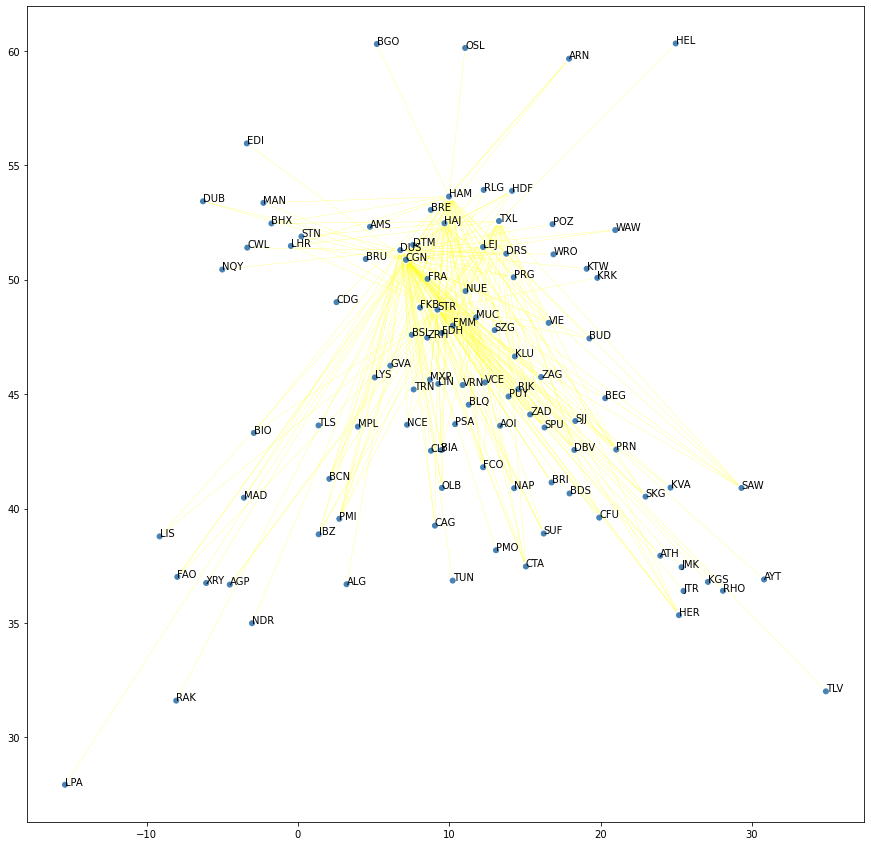

In [56]:
# visual_style = {}
# visual_style["vertex_label"] = labels
# visual_style["layout"] = loclist

# x = object
# x.coords = loclist

class MyLayout:
  coords = []

x = MyLayout()
x.coords = loclist

fig, ax = plt.subplots(figsize=(15, 15))
plot(g, target=ax, layout=x, vertex_label=labels, edge_color='yellow', edge_width=0.2)

Equirectangular map image from https://commons.wikimedia.org/wiki/File:Equirectangular_projection_SW.jpg

<a title="Strebe, CC BY-SA 3.0 &lt;https://creativecommons.org/licenses/by-sa/3.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Equirectangular_projection_SW.jpg"><img width="512" alt="Equirectangular projection SW" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/83/Equirectangular_projection_SW.jpg/512px-Equirectangular_projection_SW.jpg"></a>

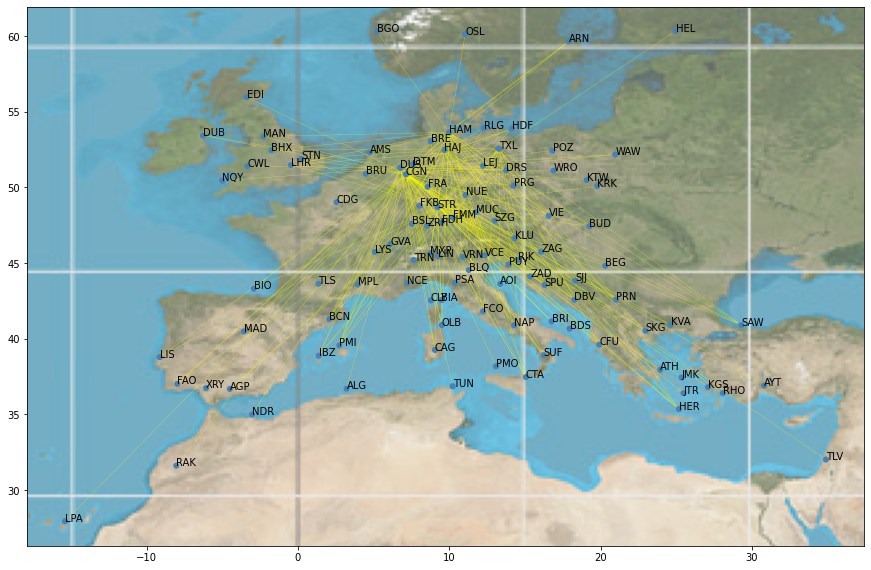

In [64]:
img = plt.imread('https://raw.githubusercontent.com/stevecoffee/dasc5300/main/Project2/Equirectangular_projection_SW.png')
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img, extent=[-180, 180, -90, 90], alpha=0.7)
plot(g, target=ax, layout=x, vertex_label=labels, edge_color='yellow', edge_width=0.2)

In [58]:
# Part 1a
# Construct a graph (or a graph data structure) for the airline being analyzed by you. With
# airport code as the vertex, draw an undirected edge between the two airports in each
# line of the input. Since many Python packages/algorithms only accept integers as vertex,
# you may have to map the 3-letter airport code into an integer. You can use a dictionary
# or something else for this purpose.

In [73]:
# Part 1b
# Using the given method, generate a few characteristics for this airline route graph. This
# will help understand some of the characteristics of the data set you are analyzing.
# Interpret them from an airlines operation perspective.
pd.set_option('display.max_rows', None)
vertices['degree'] = g.degree()
vertices['betweenness'] = g.betweenness()
vertices['evcent'] = g.evcent()

vertices.sort_values('degree', ascending=False)

,iata,airport-name,city,country,latitude,longitude,degree,betweenness,evcent
339,CGN,Cologne Bonn Airport,Cologne,Germany,50.865898,7.142740,66,2604.929297,1.000000
345,STR,Stuttgart Airport,Stuttgart,Germany,48.689899,9.221960,45,1076.387729,0.834822
337,HAM,Hamburg Airport,Hamburg,Germany,53.630402,9.988230,40,1085.308493,0.751533
340,DUS,Düsseldorf Airport,Duesseldorf,Germany,51.289501,6.766780,38,1118.321498,0.534039
346,TXL,Berlin-Tegel Airport,Berlin,Germany,52.559700,13.287700,27,515.131940,0.568101
347,HAJ,Hannover Airport,Hannover,Germany,52.461102,9.685080,17,45.410076,0.422481
1174,SPU,Split Airport,Split,Croatia,43.538898,16.298000,7,98.437605,0.334964
3786,PMI,Palma De Mallorca Airport,Palma de Mallorca,Spain,39.551701,2.738810,7,98.437605,0.334964
1168,DBV,Dubrovnik Airport,Dubrovnik,Croatia,42.561401,18.268200,6,42.412499,0.327554
1468,CTA,Catania-Fontanarossa Airport,Catania,Italy,37.466801,15.066400,6,42.412499,0.327554


In [74]:
# Part 1c
# Find the top 3 to 5 nodes (or airports; top k, in general) from where there are more
# number of flights than other nodes for that airline. These are termed hubs by an airline.
# You can use a node centrality detection algorithm/package for this
vertices.sort_values('degree', ascending=False).head(5)

,iata,airport-name,city,country,latitude,longitude,degree,betweenness,evcent
339,CGN,Cologne Bonn Airport,Cologne,Germany,50.865898,7.14274,66,2604.929297,1.000000
345,STR,Stuttgart Airport,Stuttgart,Germany,48.689899,9.22196,45,1076.387729,0.834822
337,HAM,Hamburg Airport,Hamburg,Germany,53.630402,9.98823,40,1085.308493,0.751533
340,DUS,Düsseldorf Airport,Duesseldorf,Germany,51.289501,6.76678,38,1118.321498,0.534039
346,TXL,Berlin-Tegel Airport,Berlin,Germany,52.559700,13.28770,27,515.131940,0.568101


In [61]:
# Part 1d
# Once you have the top k hubs, try to identify the airline that you are working on. You
# can use any data that is available on the Internet for this purpose. We will give you a file
# that maps airport code to airport names and cities.

#german wings - 4U

In [62]:
# Part 1e
# In this step of the analysis,
# your goal is to identify or predict the next hub for airline expansion. For this, you can
# use demographic and other information (e.g., regional) that is available on the web.
# The purpose of this step is for you to develop a feel for the analysis beyond data
# usage. We will grade you based on the ideas you use/come up with for this analysis. The
# actual airport identified as the next hub is secondary. If it matches with the actual one,
# that is great. You need to argue why your process and the publicly available data you
# have used are appropriate.

# most popular with other airlines
# access to most additional population
# use total air traffic as a proxy for revenue available at that location - give each node a value, or perhaps each edge
# come up with scoring algorhythm for a network, then try add all the nearby hubs
# calculate average distance of current legs and search for additional hubs within that range
# or assume a current stop would expand to a hub
# consider language barriers?